<a href="https://colab.research.google.com/github/VMBoehm/ML_Lectures/blob/main/IntroductionToVariationalAutoencoders_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction to Variational AutoEncoders (VAEs) and applications to physical data** 

by Vanessa Boehm (UC Berkeley and LBNL)   
Feb 27 2022


---


In this notebook we will be implementing our first Variational Autoencoder. VAEs are a useful tool for the analysis of physical data because of their probabilistic layout.   

We will start from a (non-probalistic) autoencoder and convert it into its variational counterpart.

## Autoencoder

Recall that an Auto-Encoder consists of two networks: 

1.   An encoder network that takes the data, $x$, and maps it to a lower-dimensional latent space. We will call this network $f$ and its network parameters $\phi$.
2.   A decoder network that takes the encoded data, $z$, and maps it back to the data space. We will call the result of the reconstruction $x'$, the decoder network $g$ (for generator) and its network parameters $\psi$.

$$ x' = g_\psi(f_\phi(x)) \tag{1}$$

An Auto-Encoder is trained to minimize the reconstruction error between the input $x$ and the reconstruction $x'$.

$$ \mathcal{L}_{AE}(\phi,\psi) = ||x-g_\psi(f_\phi(x))||^2_2 \tag{2}$$

---

## Probabilistic Interpretation (lecture recap)

**In a Variational Auto-Encoder we interpret the reconstruction task  probabilistically:**

Compressing the data results in a loss of information about the original data. 
If we only have access to the compressed data, we have no chance of knowing what the original data looked like *exactly*. Instead, we obtain a probability distribution over possible inputs.

$$ p(x) = \int \mathrm{d}z\, p(x|z) p(z) \tag{3}$$

Here, we have introduced two probability distributions on the right hand side, the liklelihood, $p(x|z)$, and the prior, $p(z)$.

The likelihood arises because of the information loss in the compression.

$$ x = g_\psi(f_\phi(x)) + \epsilon = g_\psi(z) + \epsilon \tag{4}$$ 

Ideally, $\epsilon$, the part of the data that is lost in the compression, is just noise and unimportant for our final data analysis. The form of the likelihood is equal to the distribution of this noise. For example, if the noise is Gaussian (which is often the case for physical data) with covariance $\Sigma_\epsilon$, the likelihood is a Gaussian distribution:

$$ p_{\psi}(x|z) = \mathcal{G}(g_\psi(z),\Sigma_\epsilon) \tag{5}$$ 

**Optional Question 1**   
Starting from $p(x|z) = \int \mathrm{d}\epsilon\, p(x,\epsilon|z)$ can you show that the likelihood follows the same distribution as $\epsilon$?

Solution:
$p(x|z) = \int \mathrm{d}\epsilon\, p(x,\epsilon|z) = \int \mathrm{d}\epsilon\, p(x|z,\epsilon) p(\epsilon) = \int \mathrm{d}\epsilon\, \delta_D(x-g(z)-\epsilon) p(\epsilon) = p(x-g(z))$ 

The prior, $p(z)$, is the average distribution of the encoded data.

$$ p(z) = \int \mathcal{d}x\, p(z|x) p(x) \tag{6}$$

In a VAE, we want the prior distribution to have closed form and to be easy to sample from (for artificial data generation). We have the freedom to choose the prior distribution as a constraint. The network training will ensure it is obeyed. A common choice is a normal distribution

$$ p(z) = \mathcal{N}(0,1) \tag{7} $$

---

### Variational Autoencoder & Evidence Lower BOund (ELBO)

To train the Variational Auto-Encoder we maximize the average log probability, $\log p(x)$, or, as we will see now, a lower bound to this quantity.

Equation (3) involves solving a fairly high dimensional integral, which is a computationally expensive and sometimes infeasible operation. This integral has to be solved not only once, but in each training step. Variational Autoencoders  solve this integral approximately by using a variational ansatz for the posterior distribution, the approximate posterior $q_\phi(z|x)$. This distribution approximates the true posterior p(z|x) and is parameterized by the encoder parameters $\phi$. 

The classic choice for the variational posterior is a multivariate Gaussian in the mean field approxiation (mean field meaning no off-diagonal terms in the covariance)

$$ q_\phi(z|x) = \mathcal{G}(\mu,\sigma_i) \tag{7} $$

where the mean, $\mu$, and variance, $\sigma$, are determined by the encoder network. 

$$(\mu, \sigma) = f_\phi(x) \tag{8} $$

As we saw in the lecture, the variational ansatz allows us to formulate a lower bound to $\log p(x)$, the Evidence Lower BOund.

$$ \log p(x) >= \int \mathrm{d}z\, q_\phi(z|x) \log{p_\psi(x|z)} - \int \mathrm{d}z\, q_\phi(z|x) \log{\frac{q_\phi(z|x)}{p(z)}} = ELBO \tag{8}$$

$$ \mathcal{L}_{VAE}(\phi,\psi) = -ELBO \tag{9}$$

The ELBO consists of two terms. The first term measures the expectation value of the likelihood over the posterior. Maximizing this term encourages high quality reconstructions (similar to the autoencoder). The second term is the KL-Divergence (a distance measure) between the variational posterior and the prior. This term acts as a regularizer. It encourages posterior distributions which are similar to the prior.

In VAE training the first term is evaluated stochastically, meaning that the expectation value is evaluated approximately by averaging over a number of samples from $q_\phi(z|x)$. The second term can be either evaluated analytically (the KL divergence between to Gaussian distributions can be calculated) or stochastically. 

---

### Reparametrization Trick

Minimizing Eq. (9) requires taking gradients with respect to $\phi$ and $\psi$. But how do we take the gradient through an expectation value?  

We use what is called the reparametrization trick. Instead of sampling from the posterior $q_\phi(z|x)$ we sample from the parameter-independent normal distribution

$$ \zeta ∼ \mathcal{N}(0,1) \tag{10}$$

and use the identity $z=\zeta*\sigma_\phi+\mu_\phi$, an operation which is trivially differentiably, to obtain our samples.

Pytorch will perform the reparametrization trick for us under the hood, if we use *distribution.rsample()* - so we don't have to code it explicitly.


Let' start by importing a few packages, that we will need later

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize

### Our dataset

In this coding exercise we will be working with a galaxy spectra sample from the SDSS-BOSS DR 16 release. The spectra have been de-redshifted to the restframe and their magnitude has been standardized to a distance correspondingg to $z_\lambda=0.1$. They have further been downsampled to 1000 pixels, denoised and inpainted where masks were present.

(I can tell you more about the data cuts and preprocessing if you are interested, but it is not relevant for this task.)

Despite being relatively high-dimensional ($d=1000$), galaxy specrtra actually reside on a lower dimensional manifold since we can compress them to much smaller dimensionality without sacrificing much reconstruction quality. 

This property makes them a very suitable data type for VAEs. 

(The same applies to image data, but images datasets are computationally more expensive to train on and they need more complicated nework architectures - things that we don't want to worry about in this exercise.)

STEP 1: Download the training and test datasets 

1.   [training set](https://drive.google.com/file/d/1oGe1zsgyCEBY1N_t-GkxxoSgVnJyTms2/view?usp=sharing)
2.   [test set](https://drive.google.com/file/d/1wXtOpUKGj2gMff2KbBfY4x8HnzxguyXJ/view?usp=sharing)

and place them in your Google Drive. (If you want to avoid having to modify the file paths in the code below, you need to create a folder called 'ML_lecture_data' and place the files in there.)


Next, we link Google Drive to this notebook

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Use this line to confirm the location of your files

In [ ]:
! ls drive/MyDrive/ML_lecture_data/

DR16_denoised_inpainted.npy	  DR16_denoised_inpainted_train.npy
DR16_denoised_inpainted_test.npy


Let's set some immutable variables:
The dimensionality of the input data and the dimensionality of the latent (encoded) space

In [ ]:
INPUT_SIZE      = 1000
LATENT_SIZE     = 6

Next we create pytorch datasets from the training and test data (note that you need to change the root_dir, if you placed the data in a different folder)

In [ ]:
class SDSS_DR16(Dataset):
    """De-redshifted and downsampled spectra from SDSS-BOSS DR16"""

    def __init__(self, root_dir='drive/MyDrive/ML_lecture_data/', transform=True, train=True):
        """
        Args:
            root_dir (string): Directory of data file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        if train:
            self.data = np.load(open(os.path.join(root_dir,'DR16_denoised_inpainted_train.npy'),'rb'),allow_pickle=True)
        else:
            self.data = np.load(open(os.path.join(root_dir,'DR16_denoised_inpainted_test.npy'),'rb'),allow_pickle=True)

        self.data = torch.as_tensor(self.data)
        self.mean = torch.mean(self.data)
        self.std  = torch.std(self.data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.data[idx]-self.mean)/self.std

        return sample




training_data = SDSS_DR16(train=True)
test_data     = SDSS_DR16(train=False)

##**Autoencoder**
This exercise starts with an Autoencoder, which is already implemented and working. The next cells walk you through the code. Your task (further below) will be to take that code and modify it into a Variational Autoencoder.

First, we define our encoder and decoder networks. We use a very simple MLP, with two linear layers and one non-linear activation function. 

In [ ]:
class Encoder(nn.Module):

    def __init__(self, seed=853):
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(INPUT_SIZE,50)
        self.fc2 = nn.Linear(50,LATENT_SIZE)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        z      = self.fc2(x)
        return z

class Decoder(nn.Module):

    def __init__(self, seed=620):
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(LATENT_SIZE,50)
        self.fc2 = nn.Linear(50,INPUT_SIZE)


    def forward(self, z):
        z = torch.nn.LeakyReLU()(self.fc1(z))
        x = self.fc2(z)
        return x

Having defined the encoder and decoder network, we can move on to define the Autoencoder.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [ ]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()

The next step is to train the Autoencoder. This is what a generic training loop looks like:

In [ ]:
# the training loop takes a function that loads the data batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterate over the dataset
    for batch, X in enumerate(dataloader):
        # Compute prediction of the model (in case of the AE the prediction is the reconstructed data)
        pred = model(X)
        # Compute the loss function (in case of the AE this is the L2 distance to the input data)
        loss = loss_fn(pred,X)

        # Backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # here we keep track of the loss
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return losses


# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for X in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg loss: {test_loss:>8f} \n")

    return test_loss


In the next cell we set the training parameters, define the loss function and create DataLoaders. Pytorch DataLoaders manage the data loading for us (break the dataset into batches, keep track of epochs, reshuffle the data after each epoch) 

In [ ]:
BATCHSIZE       = 128
BATCHSIZE_TEST  = 256
LEARNING_RATE   = 1e-3

# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)

# Dataloaders
train_dataloader = DataLoader(training_data, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=BATCHSIZE_TEST, shuffle=True)

It's finally time for training:

In [ ]:
EPOCHS = 30

train_loss = []
test_loss  = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 0.853500  [    0/100000]
loss: 0.019154  [12800/100000]
loss: 0.013171  [25600/100000]
loss: 0.005832  [38400/100000]
loss: 0.029460  [51200/100000]
loss: 0.004911  [64000/100000]
loss: 0.026111  [76800/100000]
loss: 0.015904  [89600/100000]
 Avg loss: 0.012358 

Epoch 2
-------------------------------
loss: 0.006653  [    0/100000]
loss: 0.003833  [12800/100000]
loss: 0.005910  [25600/100000]
loss: 0.003837  [38400/100000]
loss: 0.010828  [51200/100000]
loss: 0.004078  [64000/100000]
loss: 0.005897  [76800/100000]
loss: 0.012448  [89600/100000]
 Avg loss: 0.007258 

Epoch 3
-------------------------------
loss: 0.008114  [    0/100000]
loss: 0.002567  [12800/100000]
loss: 0.010473  [25600/100000]
loss: 0.029394  [38400/100000]
loss: 0.005205  [51200/100000]
loss: 0.001730  [64000/100000]
loss: 0.001933  [76800/100000]
loss: 0.001815  [89600/100000]
 Avg loss: 0.006068 

Epoch 4
-------------------------------
loss: 0.003808  [    0/100000]

Let's see how the model is doing. Let's look at 

1.   Training and test loss 
2.   Final reconstruction quality

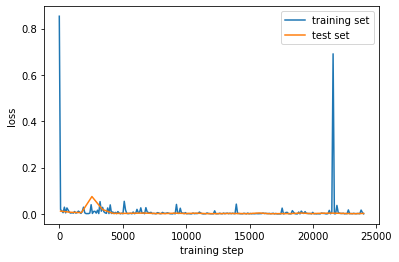

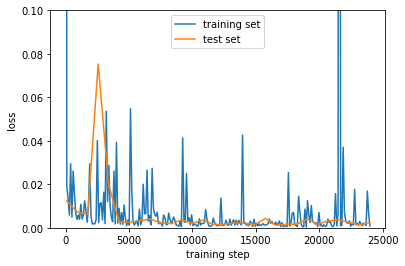

In [ ]:
# losses
length = len(np.asarray(train_loss).flatten())
plt.figure()
plt.plot(np.linspace(0,length*100,length), np.asarray(train_loss).flatten(),label='training set')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss,label='test set')
plt.xlabel('training step')
plt.ylabel('loss')
plt.legend()
plt.show()

### zoom in 
length = len(np.asarray(train_loss).flatten())
plt.figure()
plt.plot(np.linspace(0,length*100,length), np.asarray(train_loss).flatten(),label='training set')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss,label='test set')
plt.xlabel('training step')
plt.ylabel('loss')
plt.legend()
plt.ylim(0,0.1)
plt.show()

You can see that the model had a really easy time learning the task and that we haven't overfitted yet

Now, let's look at a few reconstructions:

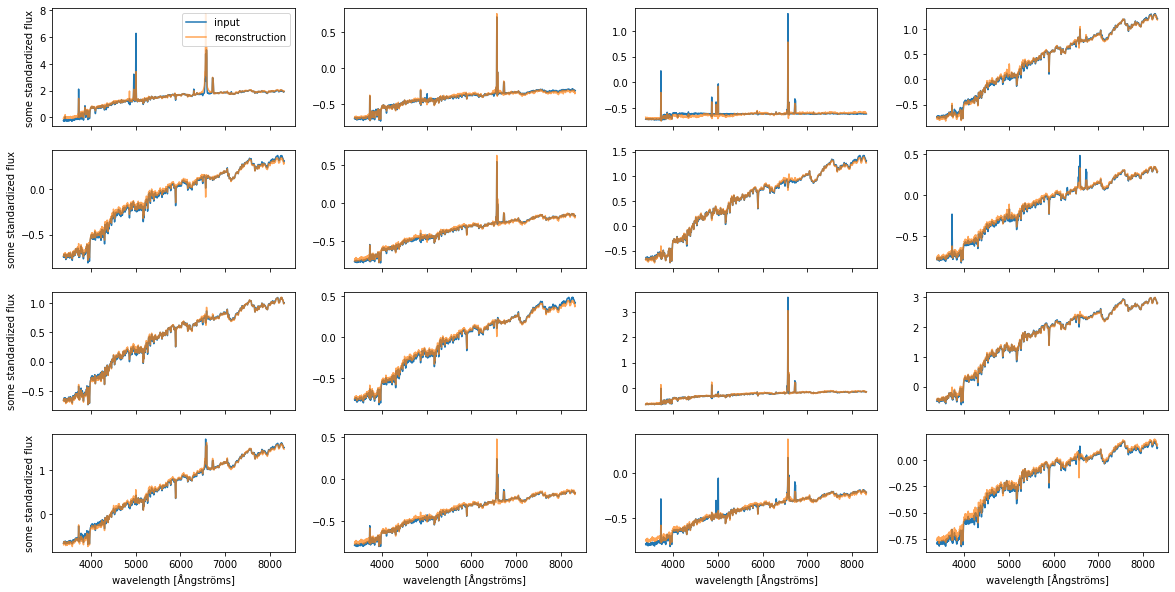

In [ ]:
test_input = next(iter(test_dataloader))

with torch.no_grad():
  recons = AE(test_input)

# This is the mapping from pixel to the de-redshifted (rest) wavelength
wlmin, wlmax      = (3388,8318)
fixed_num_bins    = 1000
wl_range          = (np.log10(wlmin),np.log10(wlmax))
wl                = np.logspace(wl_range[0],wl_range[1],fixed_num_bins)

fig, ax = plt.subplots(4,4, figsize=(20,10), sharex=True)
ax = ax.flatten()
for ii in range(16):
  ax[ii].plot(wl,test_input[ii], label='input')
  ax[ii].plot(wl,recons[ii],alpha=0.7,label='reconstruction')
  if ii in np.arange(12,16):
    ax[ii].set_xlabel('wavelength [Ångströms]')
  if ii in [0,4,8,12]:
    ax[ii].set_ylabel('some standardized flux')
  if ii==0:
    ax[ii].legend()
plt.show()

... and the average reconstruction error as a function of wavelength:

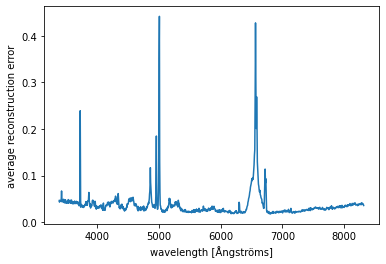

In [ ]:
avg_loss  = 0
with torch.no_grad():
    for X in test_dataloader:
        pred = AE(X)
        avg_loss+=np.mean((pred.cpu().numpy()-X.cpu().numpy())**2,axis=0)/(len(test_data)//BATCHSIZE_TEST)

plt.figure()
plt.plot(wl,np.sqrt(avg_loss))
plt.ylabel('average reconstruction error')
plt.xlabel('wavelength [Ångströms]')
plt.show()

### **Variational Autoencoder**

Your task today is to transform the above Autoencoder into a Variational Autoencoder. You can follow either follow my Step-by-Step instructions or do it your way (there's more than one solution). 

We start by modifying the encoder network. Tasks are marked with the keyword #TASK, hints are marked with the keyword #HINT.

### **STEP 1:** Modify the encoder network.
The encoder network is used to characterize the variational distribution q(z|x). Recall that we want q(z|x) to be a Gaussian with diagonal covariance. An N-dimensional Gaussian with diagonal covariance is eqivalent to N independent 1-dimensional Gaussians (where N is the latent size). Each Gaussian is defined by two quantities, its mean and variance (or, if we take the sqrt, the standard deviation).

In [ ]:
class VAEEncoder(nn.Module):

    def __init__(self, seed=853):
        super(VAEEncoder, self).__init__()
        # TASK: change the output size of the encoder network. How many parameters must it return to define q(z|x)?
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(INPUT_SIZE,50)
        self.fc2 = nn.Linear(50,LATENT_SIZE*2)

    def forward(self, x):
        # TASK: change the output of the encoder network. Instead of just returning z, it should return z and ...?
        # HINT: Don't forget that the standard deviation/variance must be strictly positive!
        # HINT: You might want to use torch.split()
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        x      = self.fc2(x)
        mu,std = torch.split(x, LATENT_SIZE,dim=-1)
        std    = torch.exp(std) + 1e-8
        return mu, std


### **STEP 2:** Modify the decoder network.

We will leave our decoder network as it is :)

In [ ]:
class VAEDecoder(nn.Module):

    def __init__(self, seed=620):
        super(VAEDecoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(LATENT_SIZE,50)
        self.fc2 = nn.Linear(50,INPUT_SIZE)

    def forward(self, z):
        z = torch.nn.LeakyReLU()(self.fc1(z))
        x = self.fc2(z)
        return x

Since we work with probability distributions in the VAE, we need to import the torch distributions package. We will only need the normal distribution for this exercise. 

In [ ]:
#TASK: Familiarize yourself with torch.distribution.Normal - you can find the documentation here: https://pytorch.org/docs/stable/distributions.html#normal
#HINT: It takes a standard deviation (scale) not a variance as input
from torch.distributions import Normal as Normal 

### **STEP 2:** Modify the AE class into a VAE class!



1.   A VAE has a few more input parameters than an AE. We need a sample size, which determines how many samples we draw from $q_\phi(z|x)$ for evaluating the ELBO. We also need a $\sigma_\epsilon$ to characterize the likelihood, $p_\psi(x|z)=\mathcal{G}(x',\sigma_\epsilon)$.
2.   The prior is fixed. We can define it in the beginning, when we initialize the VAE.
3.   We need methods to compute the variational posterior, the likelihood, the KL-divergence and the ELBO.



In [ ]:
class VariationalAutoencoder(nn.Module):
    #TASK: add parameters mentioned in point 1. 
    def __init__(self, sample_size, sigma):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()
        self.sample_size = sample_size
        self.sigma       = sigma
        #TASK: Use the Normal class to define the prior (a standard normal distribution), p(z)
        self.prior       = Normal(torch.zeros(LATENT_SIZE), torch.ones(LATENT_SIZE))

    def change_sample_size(self,sample_size):
        self.sample_size = sample_size
        return True

    def get_q(self,x):
        #TASK: write a method that computes q(z,x)
        #HINT: use the Normal class we imported above
        mu, std = self.encoder(x)
        self.q = Normal(mu, std)
        return True

    def sample_q(self):
        #TASK: write a method that samples from q
        #HINT: use rsample to apply the reparameterization trick
        z_sample = self.q.rsample(torch.Size([self.sample_size]))
        #z_sample = torch.reshape(z_sample,[-1,LATENT_SIZE])
        #print(z_sample.shape)
        return z_sample

    def get_avg_log_likelihood(self,recons,x):
        #TASK: Write a method that returns the first term in the ELBO (this method should define the likelihood and evaluate the average log likelihood of the reconstruction)
        #HINT: Pay attention to shapes. The function should return an average log likelihood (a single number) for every data point in the batch.
        #HINT: The output shape of Normal(mu, sigma).log_prob() is a little unintuitive. If mu or sigma are N-dimensional, it returns N results (applies N independent Gaussians). 
        #HINT: You need to average over samples from q to obtain the final result.
        ll    = Normal(x[None,:,:], self.sigma)
        log_p = ll.log_prob(recons)
        log_p = torch.sum(log_p,dim=-1)
        return torch.mean(log_p,dim=0)

    def stochastic_kl_divergence(self,z_sample):
        #TASK: write a method that computes the kl-divergence between q(z|x) and p(z) 
        return torch.mean(torch.sum(self.q.log_prob(z_sample),dim=-1)-torch.sum(self.prior.log_prob(z_sample),dim=-1), dim=0)

    def forward(self, x):
        #TASK: a forward pass should return the two terms in the ELBO
        #HINT: use all methods we defined above
        self.get_q(x)
        samples = self.sample_q()
        recons  = self.decoder(samples)
        log_likelihood = self.get_avg_log_likelihood(recons,x)
        kl      = self.stochastic_kl_divergence(samples)
        return log_likelihood, kl

### **STEP 3**: Prepare for training

In [ ]:
#TASK: create an instance of the Variational Autoencoder
VAE = VariationalAutoencoder(4,sigma=1)

optimizer = torch.optim.Adam(VAE.parameters(), lr=LEARNING_RATE)


#from torch.optim.lr_scheduler import StepLR
#scheduler = StepLR(optimizer, step_size=10, gamma=0.75)

In [ ]:
#TASK: define the new loss function
def negative_ELBO(avg_log_likelihood,kl):

    negative_ELBO = - torch.mean(avg_log_likelihood-kl)

    return negative_ELBO

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        #TASK: compute the loss from the output of the VAE foward pass  
        log_likelihood, kl = model(X)
        loss = loss_fn(log_likelihood,kl)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    #scheduler.step()
    return losses


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, nllh, kl_ = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for X in dataloader:
            #TASK: in the test loop we want to keep track not only of the ELBO, but also of the two terms that contribute to the ELBO (kl diveregence and loglikelihood)
            log_likelihood, kl = model(X)
            test_loss += loss_fn(log_likelihood,kl).item()
            nllh += -np.mean(log_likelihood.cpu().numpy())
            kl_ += np.mean(kl.cpu().numpy())


    test_loss /= num_batches
    kl_ /= num_batches
    nllh /= num_batches

    print(f" Avg test loss      : {test_loss:>8f}")
    print(f" Avg KL             : {kl_:>8f}")
    print(f" Avg negative log likelihood : {nllh:>8f} \n")

    return test_loss, kl_, nllh


Let's train!

In [ ]:
EPOCHS = 20

train_loss = []
test_loss  = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, VAE, negative_ELBO, optimizer))
    test_loss.append(test_loop(test_dataloader, VAE, negative_ELBO))
print("Done!")

Epoch 1
-------------------------------
loss: 1375.223511  [    0/100000]
loss: 3931.379395  [12800/100000]
loss: 3819.429443  [25600/100000]
loss: 1936.327881  [38400/100000]
loss: 2728.390625  [51200/100000]
loss: 2815.364258  [64000/100000]
loss: 1917.122314  [76800/100000]
loss: 2264.723389  [89600/100000]
 Avg test loss      : 2096.136879
 Avg KL             : 238.523540
 Avg negative log likelihood : 1857.613340 

Epoch 2
-------------------------------
loss: 1551.133423  [    0/100000]
loss: 1513.162964  [12800/100000]
loss: 1616.551025  [25600/100000]
loss: 1575.843140  [38400/100000]
loss: 1645.895996  [51200/100000]
loss: 1462.239014  [64000/100000]
loss: 1514.537476  [76800/100000]
loss: 1472.657715  [89600/100000]
 Avg test loss      : 1412.819215
 Avg KL             : 134.747134
 Avg negative log likelihood : 1278.072092 

Epoch 3
-------------------------------
loss: 1618.178223  [    0/100000]
loss: 1379.213501  [12800/100000]
loss: 1225.213135  [25600/100000]
loss: 1227

In [ ]:
test_loss = np.asarray(test_loss)

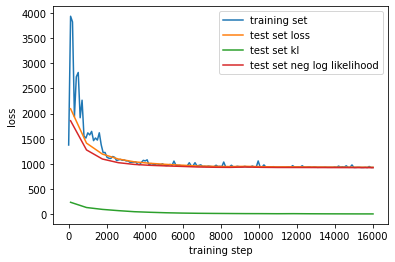

In [ ]:
#TASK: plot the training loss, test loss, and the contributions to teh loss from each of the two terms 
length = len(np.asarray(train_loss).flatten())
plt.figure()
plt.plot(np.linspace(0,length*100,length), np.asarray(train_loss).flatten(),label='training set')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,0],label='test set loss')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,1],label='test set kl')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,2],label='test set neg log likelihood')
plt.xlabel('training step')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# TASK: Inspect how the contribution of the kl divergence and log likelihood to the loss change as you change the noise in the likelihood. Some suggested values: sigma=[0.5,1,2]
# TASK: what ahppens if you change the number of samples?
# What do you observe? Can you interpret it?

### **STEP 4:** Inspect the model performance

Similar to the AE, we will look at the average reconstruction quality. But in addition, we also want to know how well the kl term was minimized. We will therefore look at three things

1.   Reconstruction quality
2.   Scatter plots of posterior samples and prior samples. Recall that $p(z)=\int \mathcal{d}x\, p(x,z) \approx \frac{1}{N_{samples}} \sum_{x\sim p(x)} p(z|x)$.
3.   Quality of artificial data generation


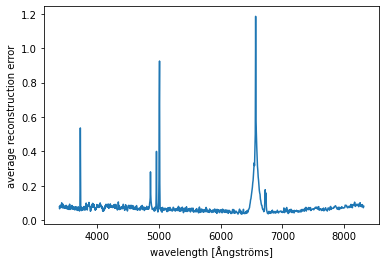

In [ ]:
 #TASK: plot the average reconstruction error of the model as a function of wavelength (similar to above). How does it compare to the Autoencoder?
 #HINT: Use the mean of $q(z|x)$ as the latent point for data x
avg_loss  = 0
VAE.eval()
with torch.no_grad():
    for X in test_dataloader:
        pred = VAE.decoder(VAE.encoder(X)[0])
        avg_loss+=np.mean((pred.cpu().numpy()-X.cpu().numpy())**2,axis=0)/(len(test_data)//BATCHSIZE_TEST)

plt.figure()
plt.plot(wl,np.sqrt(avg_loss))
plt.ylabel('average reconstruction error')
plt.xlabel('wavelength [Ångströms]')
plt.show()

(30000, 6)
(30208, 6)


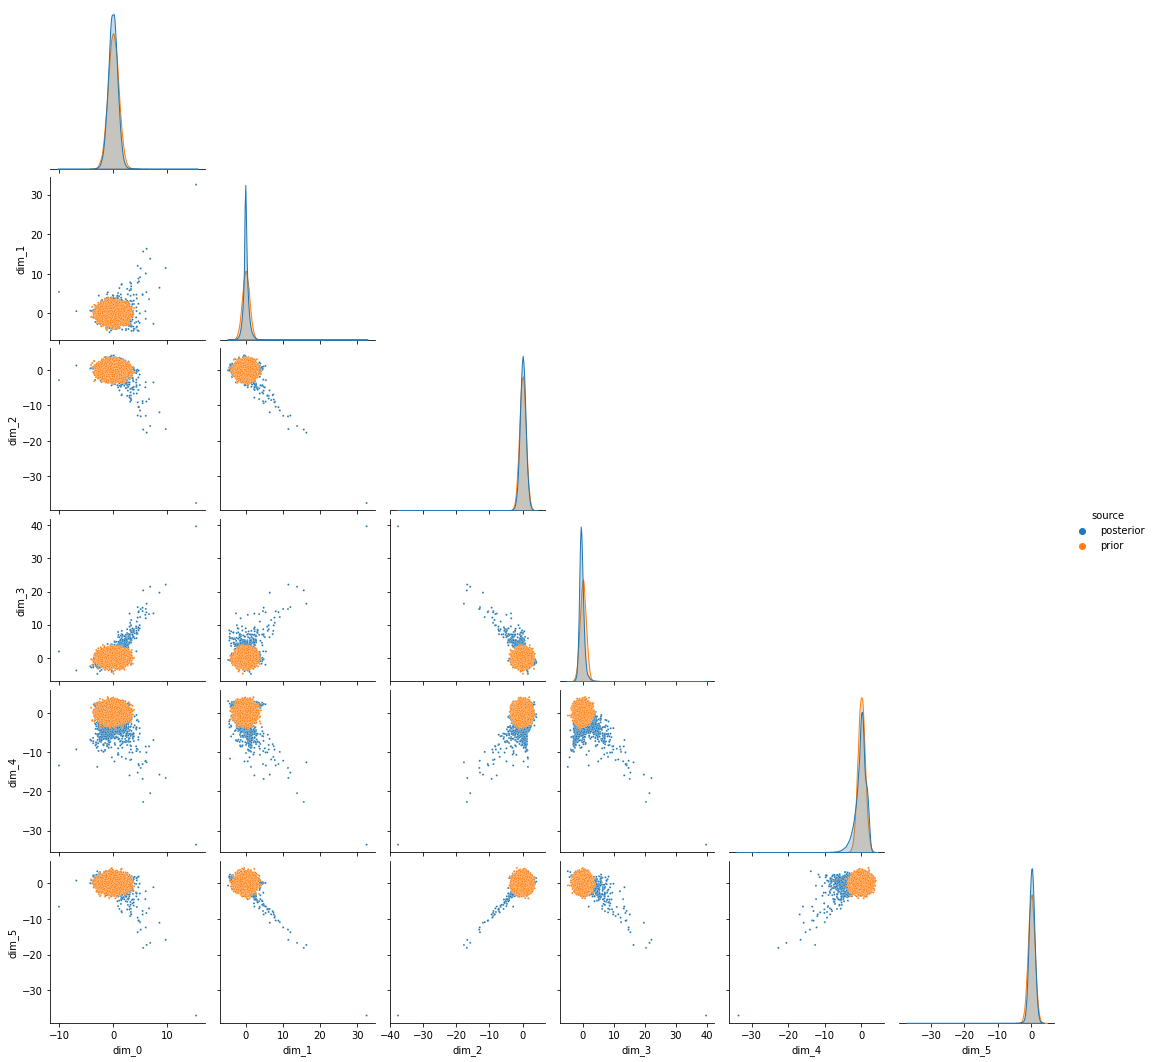

In [ ]:
#TASK: make a corner plot of posterior samples. Does the average posterior match the prior?

import seaborn as sns
import pandas as pd

VAE.eval()
with torch.no_grad():
    for ii, X in enumerate(test_dataloader):
        VAE.get_q(X)
        prior_sample = VAE.prior.sample([BATCHSIZE_TEST])
        sample       = VAE.sample_q().cpu().numpy()[0:1].swapaxes(0,1)
        if ii==0:
          samples       = sample
          prior_samples = prior_sample
        else:
          samples       = np.vstack([samples, sample])
          prior_samples = np.vstack([prior_samples, prior_sample])

samples       = np.reshape(samples,[-1, LATENT_SIZE])
prior_samples = np.reshape(prior_samples,[-1, LATENT_SIZE])

print(samples.shape)
print(prior_samples.shape)

data1    = pd.DataFrame()
data2    = pd.DataFrame()

for ii in range(LATENT_SIZE):
  data1['dim_%d'%ii] = samples[:,ii]
data1['source'] = 'posterior'

for ii in range(LATENT_SIZE):
  data2['dim_%d'%ii] = prior_samples[:,ii]
data2['source'] = 'prior'

data = pd.concat([data1,data2]).reset_index(drop=True)


#HINT: to get a density estimate you can set kind='kde', but you'll probably have to reduce the number of samples, or try 'hist' instead
sns.pairplot(data,corner=True,kind='scatter', hue='source', plot_kws={'s':4})
plt.show()

In [ ]:
#TASK: Generate artificial data: sample from the prior and foward model the sample thorugh the decoder. Do the samples look realistic? Why?/Why not?

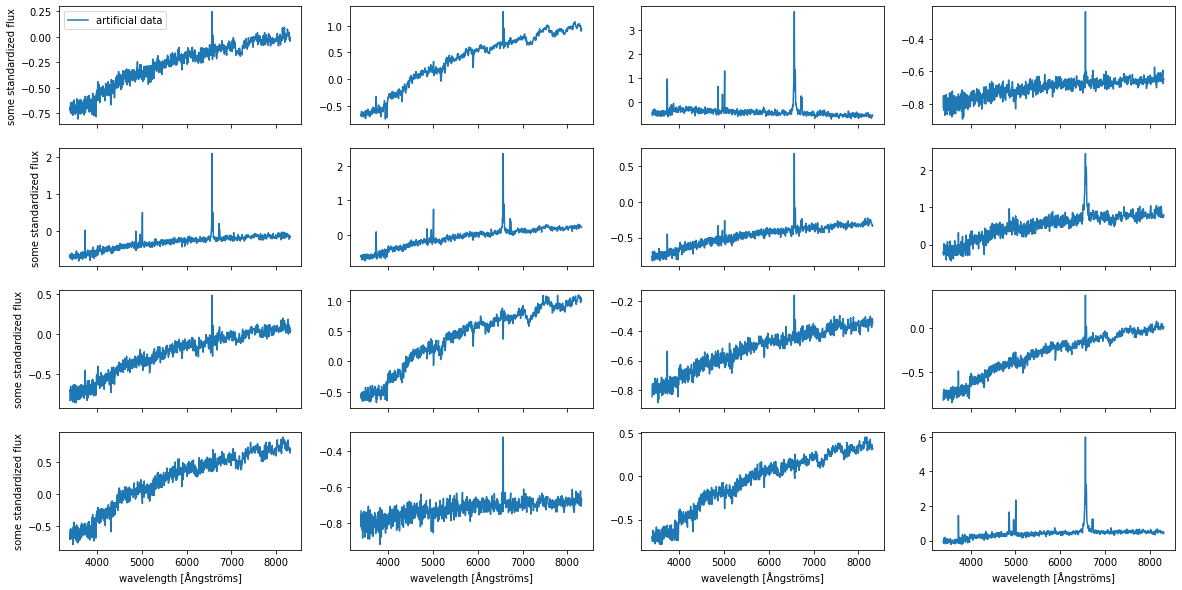

In [ ]:
VAE.eval()
with torch.no_grad():
  samples = VAE.prior.sample([16])
  data_samples = VAE.decoder(samples)

# This is the mapping from pixel to the de-redshifted (rest) wavelength
wlmin, wlmax      = (3388,8318)
fixed_num_bins    = 1000
wl_range          = (np.log10(wlmin),np.log10(wlmax))
wl                = np.logspace(wl_range[0],wl_range[1],fixed_num_bins)

fig, ax = plt.subplots(4,4, figsize=(20,10), sharex=True)
ax = ax.flatten()
for ii in range(16):
  ax[ii].plot(wl,data_samples[ii], label='artificial data')
  if ii in np.arange(12,16):
    ax[ii].set_xlabel('wavelength [Ångströms]')
  if ii in [0,4,8,12]:
    ax[ii].set_ylabel('some standardized flux')
  if ii==0:
    ax[ii].legend()
plt.show()

In [ ]:
torch.save(VAE.state_dict(), 'drive/MyDrive/ML_lecture_models/VAE_model_weights.pth')

In [ ]:
torch.save(VAE.encoder.state_dict(), 'drive/MyDrive/ML_lecture_models/Encoder_model_weights.pth')

In [ ]:
torch.save(VAE.decoder.state_dict(), 'drive/MyDrive/ML_lecture_models/Decoder_model_weights.pth')

In [ ]:
VAE.load_state_dict(torch.load('drive/MyDrive/ML_lecture_models/VAE_model_weights.pth'))

<All keys matched successfully>